# 🚀 XGBoost Regression with PCA: DAT Binding Prediction

**Goal**: Predict pKi values (binding strength) using XGBoost with **PCA-transformed features**

**Dataset**: 541 compounds with PCA components (from dataanalyse.ipynb)  
**Target**: pKi (continuous variable)  
**Method**: XGBoost Regression + 80/20 Train/Test Split + PCA  
**Key Difference**: Uses **PCA components** instead of raw RDKit descriptors

**Why PCA?**
- Reduces dimensionality (17 features → fewer components)
- Removes multicollinearity between features
- Can improve model generalization
- Faster training with fewer features

---


In [28]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import randint, uniform
import time

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [29]:
def kfold_cv_xgb_pca(X, y, n_splits=5, random_state=42):
    """
    Standardized K-fold cross-validation for XGBoost with PCA features.
    """
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=random_state,
        n_jobs=-1
    )
    
    # Cross-validate with multiple metrics
    cv_results = cross_validate(
        model, X, y, cv=kfold,
        scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'],
        return_train_score=False, n_jobs=-1
    )
    
    # Extract and format results
    r2_scores = cv_results['test_r2']
    rmse_scores = -cv_results['test_neg_root_mean_squared_error']
    mae_scores = -cv_results['test_neg_mean_absolute_error']
    
    fold_df = pd.DataFrame({
        'Fold': range(1, n_splits + 1),
        'R²': r2_scores,
        'RMSE': rmse_scores,
        'MAE': mae_scores
    })
    
    return {
        'r2_mean': r2_scores.mean(),
        'r2_std': r2_scores.std(),
        'rmse_mean': rmse_scores.mean(),
        'rmse_std': rmse_scores.std(),
        'mae_mean': mae_scores.mean(),
        'mae_std': mae_scores.std(),
        'fold_scores': fold_df
    }

print("✅ K-fold CV utilities loaded for XGBoost (PCA)")


✅ K-fold CV utilities loaded for XGBoost (PCA)


In [30]:
# Load pre-computed PCA features from data analysis
df_pca = pd.read_csv('saved_models/processed_DAT_pca_features.csv')

# Extract features and target
X = df_pca.drop(['ChEMBL_ID', 'pKi'], axis=1).values
y = df_pca['pKi'].values
n_components = X.shape[1]

print("="*60)
print("📂 LOADED PRE-COMPUTED PCA DATA")
print("="*60)
print(f"✅ Dataset: {len(df_pca)} compounds")
print(f"✅ PCA components: {n_components} (95% variance from dataanalyse.ipynb)")
print(f"✅ Source: saved_models/processed_DAT_pca_features.csv")
print(f"\n📊 pKi distribution:")
print(f"   Min: {y.min():.2f}")
print(f"   Max: {y.max():.2f}")
print(f"   Mean: {y.mean():.2f}")
print(f"   Median: {np.median(y):.2f}")
print(f"\n💡 PCA already applied - consistent across all PCA models!")
print("="*60)

📂 LOADED PRE-COMPUTED PCA DATA
✅ Dataset: 541 compounds
✅ PCA components: 8 (95% variance from dataanalyse.ipynb)
✅ Source: saved_models/processed_DAT_pca_features.csv

📊 pKi distribution:
   Min: 3.41
   Max: 10.40
   Mean: 6.92
   Median: 6.95

💡 PCA already applied - consistent across all PCA models!


## 📂 Step 1: Load Pre-computed PCA Data

**Source:** `saved_models/processed_DAT_pca_features.csv` (from dataanalyse.ipynb)

**Process:**
1. Load pre-computed PCA components (8 components, 95% variance)
2. PCA was already applied in dataanalyse.ipynb - ensures consistency
3. Split into train/test (80/20)
4. Use PCA components directly for XGBoost training


## 📊 Step 1b: Standardized 5-Fold Cross-Validation (PCA)

Running K-fold CV to match other models in the comparison workflow

In [31]:
# Run 5-fold CV on the full PCA dataset
print("="*70)
print("🔄 Running 5-Fold Cross-Validation for XGBoost (PCA)")
print("="*70)

start_time = time.time()
cv_results_xgb_pca = kfold_cv_xgb_pca(X, y, n_splits=5, random_state=42)
cv_time = time.time() - start_time

print("\n" + "="*70)
print("📊 K-FOLD CV RESULTS (5 folds) - PCA Features")
print("="*70)
print(f"R²:   {cv_results_xgb_pca['r2_mean']:.4f} ± {cv_results_xgb_pca['r2_std']:.4f}")
print(f"RMSE: {cv_results_xgb_pca['rmse_mean']:.4f} ± {cv_results_xgb_pca['rmse_std']:.4f}")
print(f"MAE:  {cv_results_xgb_pca['mae_mean']:.4f} ± {cv_results_xgb_pca['mae_std']:.4f}")
print(f"Computation Time: {cv_time:.2f} seconds")
print("="*70)

# Per-fold breakdown
print("\nPer-Fold Performance:")
print(cv_results_xgb_pca['fold_scores'].to_string(index=False))

🔄 Running 5-Fold Cross-Validation for XGBoost (PCA)

📊 K-FOLD CV RESULTS (5 folds) - PCA Features
R²:   0.5408 ± 0.0813
RMSE: 0.7807 ± 0.0482
MAE:  0.5919 ± 0.0238
Computation Time: 7.68 seconds

Per-Fold Performance:
 Fold       R²     RMSE      MAE
    1 0.472613 0.826799 0.595112
    2 0.549389 0.755674 0.589050
    3 0.430580 0.846055 0.625197
    4 0.595841 0.758337 0.599034
    5 0.655519 0.716560 0.551260


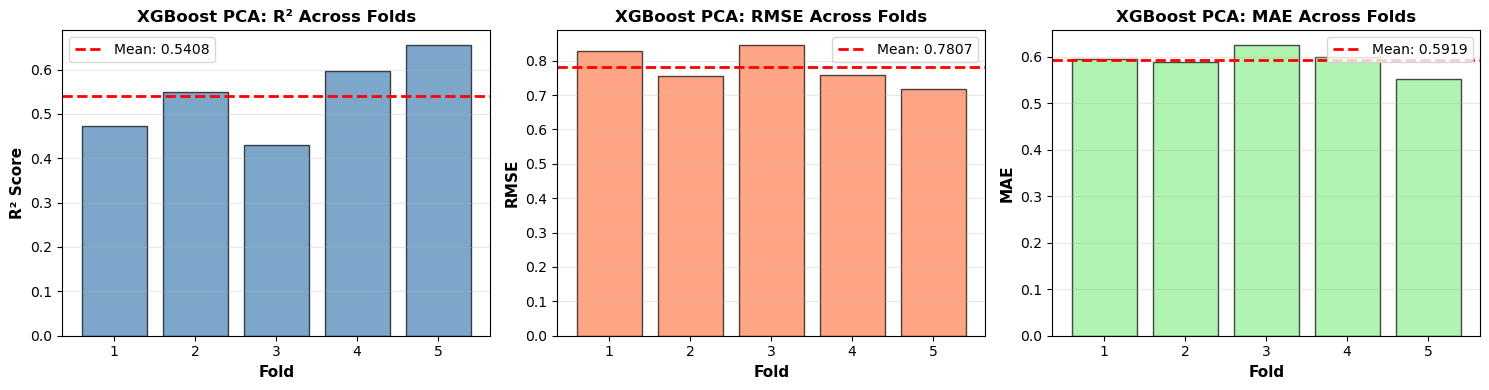

✅ Cross-validation metrics visualized


In [32]:
# Visualize CV metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# R² across folds
axes[0].bar(range(1, 6), cv_results_xgb_pca['fold_scores']['R²'], alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axhline(cv_results_xgb_pca['r2_mean'], color='red', linestyle='--', linewidth=2, 
                label=f"Mean: {cv_results_xgb_pca['r2_mean']:.4f}")
axes[0].set_xlabel('Fold', fontsize=11, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes[0].set_title('XGBoost PCA: R² Across Folds', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# RMSE across folds
axes[1].bar(range(1, 6), cv_results_xgb_pca['fold_scores']['RMSE'], alpha=0.7, color='coral', edgecolor='black')
axes[1].axhline(cv_results_xgb_pca['rmse_mean'], color='red', linestyle='--', linewidth=2, 
                label=f"Mean: {cv_results_xgb_pca['rmse_mean']:.4f}")
axes[1].set_xlabel('Fold', fontsize=11, fontweight='bold')
axes[1].set_ylabel('RMSE', fontsize=11, fontweight='bold')
axes[1].set_title('XGBoost PCA: RMSE Across Folds', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# MAE across folds
axes[2].bar(range(1, 6), cv_results_xgb_pca['fold_scores']['MAE'], alpha=0.7, color='lightgreen', edgecolor='black')
axes[2].axhline(cv_results_xgb_pca['mae_mean'], color='red', linestyle='--', linewidth=2, 
                label=f"Mean: {cv_results_xgb_pca['mae_mean']:.4f}")
axes[2].set_xlabel('Fold', fontsize=11, fontweight='bold')
axes[2].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes[2].set_title('XGBoost PCA: MAE Across Folds', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Cross-validation metrics visualized")

### Variance & Computation Time Analysis (PCA)

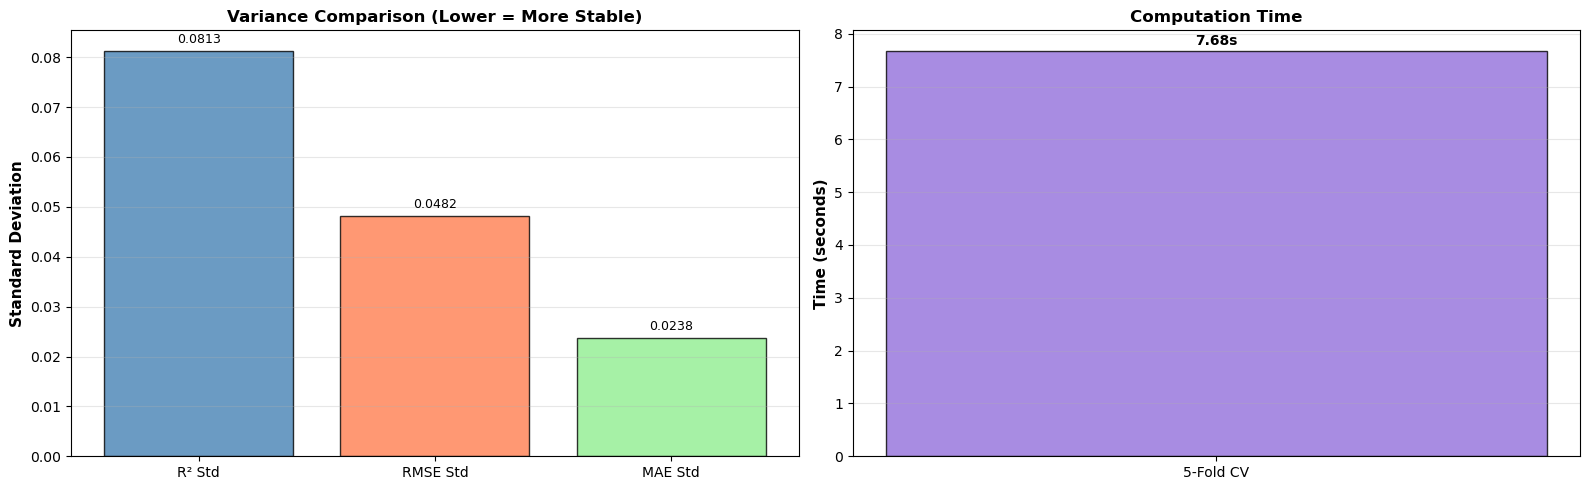

✅ Variance and timing analysis visualized for XGBoost (PCA)


In [33]:
# Variance and Computation Time Visualization (PCA)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left panel: Variance Comparison (Lower = More Stable)
variance_data = [cv_results_xgb_pca['r2_std'], cv_results_xgb_pca['rmse_std'], cv_results_xgb_pca['mae_std']]
variance_labels = ['R² Std', 'RMSE Std', 'MAE Std']
colors_variance = ['steelblue', 'coral', 'lightgreen']

x_pos = np.arange(len(variance_labels))
axes[0].bar(x_pos, variance_data, alpha=0.8, color=colors_variance, edgecolor='black')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(variance_labels)
axes[0].set_ylabel('Standard Deviation', fontsize=11, fontweight='bold')
axes[0].set_title('Variance Comparison (Lower = More Stable)', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(variance_data):
    axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# Right panel: Computation Time
axes[1].bar([0], [cv_time], alpha=0.8, color='mediumpurple', edgecolor='black', width=0.5)
axes[1].set_xticks([0])
axes[1].set_xticklabels(['5-Fold CV'])
axes[1].set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[1].set_title('Computation Time', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value label on bar
axes[1].text(0, cv_time + 0.05, f'{cv_time:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Variance and timing analysis visualized for XGBoost (PCA)")

In [34]:
# Data already loaded in Cell 3 - ready for train/test split
print("="*60)
print("✅ Using X and y from Cell 3 (PCA features already loaded)")
print("="*60)


✅ Using X and y from Cell 3 (PCA features already loaded)


## 🔄 Step 2: Split Data (80/20 Train/Test)


In [35]:
# 80/20 Train-Test Split (on PCA components)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Standardize PCA components for XGBoost training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("="*60)
print("📊 TRAIN/TEST SPLIT COMPLETED")
print("="*60)
print(f"✅ Training set: {len(X_train)} compounds ({len(X_train)/len(X)*100:.1f}%)")
print(f"✅ Test set: {len(X_test)} compounds ({len(X_test)/len(X)*100:.1f}%)")
print(f"✅ Features: {n_components} PCA components (scaled)")
print(f"✅ Target: pKi values")
print("="*60)


📊 TRAIN/TEST SPLIT COMPLETED
✅ Training set: 432 compounds (79.9%)
✅ Test set: 109 compounds (20.1%)
✅ Features: 8 PCA components (scaled)
✅ Target: pKi values


## 🎯 Step 4: Train Baseline XGBoost Model on PCA Features


In [36]:
# Initialize baseline XGBoost model
xgb_baseline = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,

)

print("🚀 Training Baseline XGBoost Model (PCA Features)...")

# Train with early stopping (on scaled PCA components)
xgb_baseline.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

# Predictions (on scaled data)
y_train_pred = xgb_baseline.predict(X_train_scaled)
y_test_pred = xgb_baseline.predict(X_test_scaled)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n" + "="*70)
print("📊 BASELINE XGBOOST MODEL PERFORMANCE (PCA)")
print("="*70)
print(f"\n{'Metric':<20} {'Training Set':<20} {'Test Set':<20}")
print("-"*70)
print(f"{'R² Score':<20} {train_r2:<20.4f} {test_r2:<20.4f}")
print(f"{'RMSE':<20} {train_rmse:<20.4f} {test_rmse:<20.4f}")
print(f"{'MAE':<20} {train_mae:<20.4f} {test_mae:<20.4f}")
print("-"*70)
overfit_r2 = train_r2 - test_r2
print(f"\n🔍 Overfitting: {overfit_r2:.4f} ({'Good' if overfit_r2 < 0.05 else 'Mild' if overfit_r2 < 0.1 else 'High'})")
print("="*70)


🚀 Training Baseline XGBoost Model (PCA Features)...

📊 BASELINE XGBOOST MODEL PERFORMANCE (PCA)

Metric               Training Set         Test Set            
----------------------------------------------------------------------
R² Score             0.8669               0.4904              
RMSE                 0.4272               0.8127              
MAE                  0.3382               0.6336              
----------------------------------------------------------------------

🔍 Overfitting: 0.3765 (High)


## 📈 Step 5: Visualizations


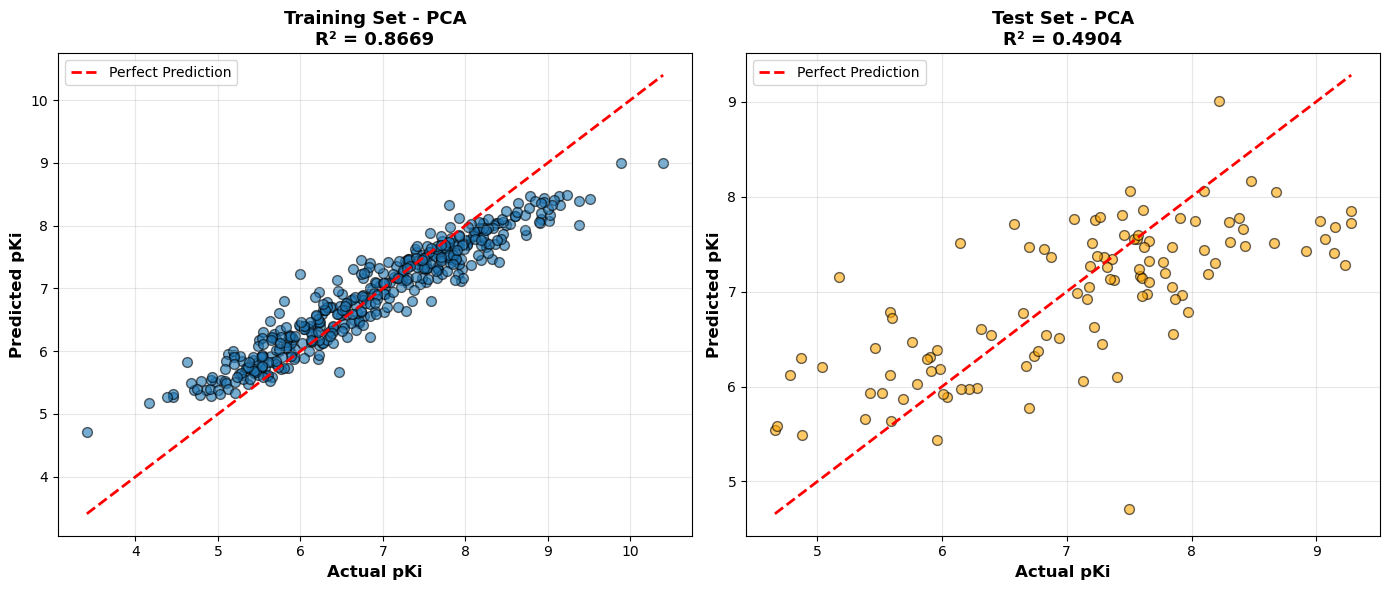

In [37]:
# Actual vs Predicted plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_train, y_train_pred, alpha=0.6, edgecolors='black', s=50)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual pKi', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Set - PCA\nR² = {train_r2:.4f}', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].scatter(y_test, y_test_pred, alpha=0.6, edgecolors='black', s=50, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual pKi', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Set - PCA\nR² = {test_r2:.4f}', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 🔧 Step 6: Hyperparameter Tuning


In [38]:
# Define parameter distributions
param_distributions = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 7),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 2)
}

xgb_tuning = XGBRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb_tuning,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("🔍 Starting hyperparameter tuning (100 iterations, 5-fold CV)...\n")
random_search.fit(X_train_scaled, y_train)

best_xgb_model = random_search.best_estimator_

# Evaluate tuned model (on scaled data)
y_train_pred_tuned = best_xgb_model.predict(X_train_scaled)
y_test_pred_tuned = best_xgb_model.predict(X_test_scaled)

train_r2_tuned = r2_score(y_train, y_train_pred_tuned)
test_r2_tuned = r2_score(y_test, y_test_pred_tuned)
test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
test_mae_tuned = mean_absolute_error(y_test, y_test_pred_tuned)

print("\n" + "="*70)
print("✅ TUNED MODEL PERFORMANCE (PCA)")
print("="*70)
print(f"Test R²: {test_r2_tuned:.4f} (baseline: {test_r2:.4f})")
print(f"Test RMSE: {test_rmse_tuned:.4f} (baseline: {test_rmse:.4f})")
print(f"Test MAE: {test_mae_tuned:.4f} (baseline: {test_mae:.4f})")
print(f"\nImprovement: {((test_r2_tuned - test_r2) / abs(test_r2) * 100):+.2f}%")
print("="*70)


🔍 Starting hyperparameter tuning (100 iterations, 5-fold CV)...

Fitting 5 folds for each of 100 candidates, totalling 500 fits



✅ TUNED MODEL PERFORMANCE (PCA)
Test R²: 0.4769 (baseline: 0.4904)
Test RMSE: 0.8234 (baseline: 0.8127)
Test MAE: 0.6358 (baseline: 0.6336)

Improvement: -2.75%


## 📈 Step 6.5: Tuned Model Visualizations


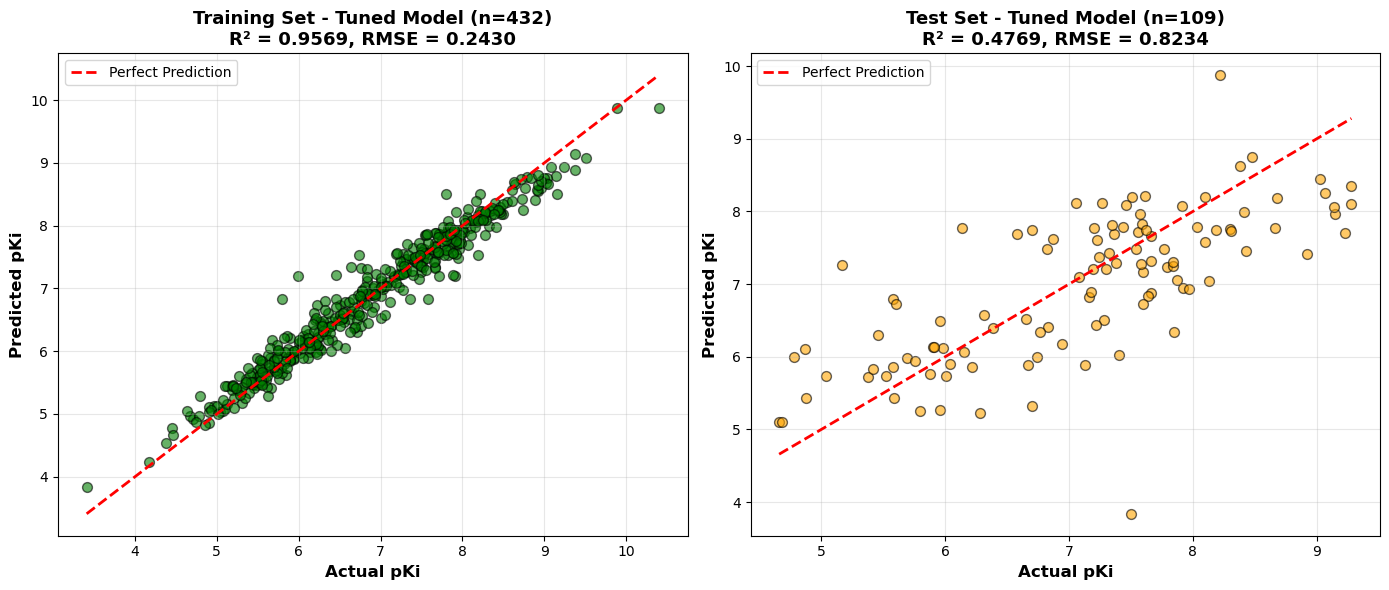


📊 TUNED MODEL PERFORMANCE SUMMARY (PCA)

Metric               Training Set         Test Set            
----------------------------------------------------------------------
R² Score             0.9569               0.4769              
RMSE                 0.2430               0.8234              
MAE                  0.1797               0.6358              
----------------------------------------------------------------------

🔍 Overfitting Analysis:
   R² difference (train - test): 0.4800
   ⚠️  Potential overfitting detected!


In [39]:
# Calculate train metrics for tuned model (needed for plots)
train_rmse_tuned = np.sqrt(mean_squared_error(y_train, y_train_pred_tuned))
train_mae_tuned = mean_absolute_error(y_train, y_train_pred_tuned)

# Actual vs Predicted plots for Tuned Model
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set
axes[0].scatter(y_train, y_train_pred_tuned, alpha=0.6, edgecolors='black', s=50, color='green')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual pKi', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Set - Tuned Model (n={len(y_train)})\nR² = {train_r2_tuned:.4f}, RMSE = {train_rmse_tuned:.4f}', 
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_tuned, alpha=0.6, edgecolors='black', s=50, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual pKi', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Set - Tuned Model (n={len(y_test)})\nR² = {test_r2_tuned:.4f}, RMSE = {test_rmse_tuned:.4f}', 
                  fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("📊 TUNED MODEL PERFORMANCE SUMMARY (PCA)")
print("="*70)
print(f"\n{'Metric':<20} {'Training Set':<20} {'Test Set':<20}")
print("-"*70)
print(f"{'R² Score':<20} {train_r2_tuned:<20.4f} {test_r2_tuned:<20.4f}")
print(f"{'RMSE':<20} {train_rmse_tuned:<20.4f} {test_rmse_tuned:<20.4f}")
print(f"{'MAE':<20} {train_mae_tuned:<20.4f} {test_mae_tuned:<20.4f}")
print("-"*70)

# Check for overfitting
overfit_r2_tuned = train_r2_tuned - test_r2_tuned
print(f"\n🔍 Overfitting Analysis:")
print(f"   R² difference (train - test): {overfit_r2_tuned:.4f}")
if overfit_r2_tuned > 0.1:
    print(f"   ⚠️  Potential overfitting detected!")
elif overfit_r2_tuned > 0.05:
    print(f"   ⚡ Mild overfitting")
else:
    print(f"   ✅ Good generalization!")
print("="*70)


## 🎯 Step 7: Classification Performance (Confusion Matrix)


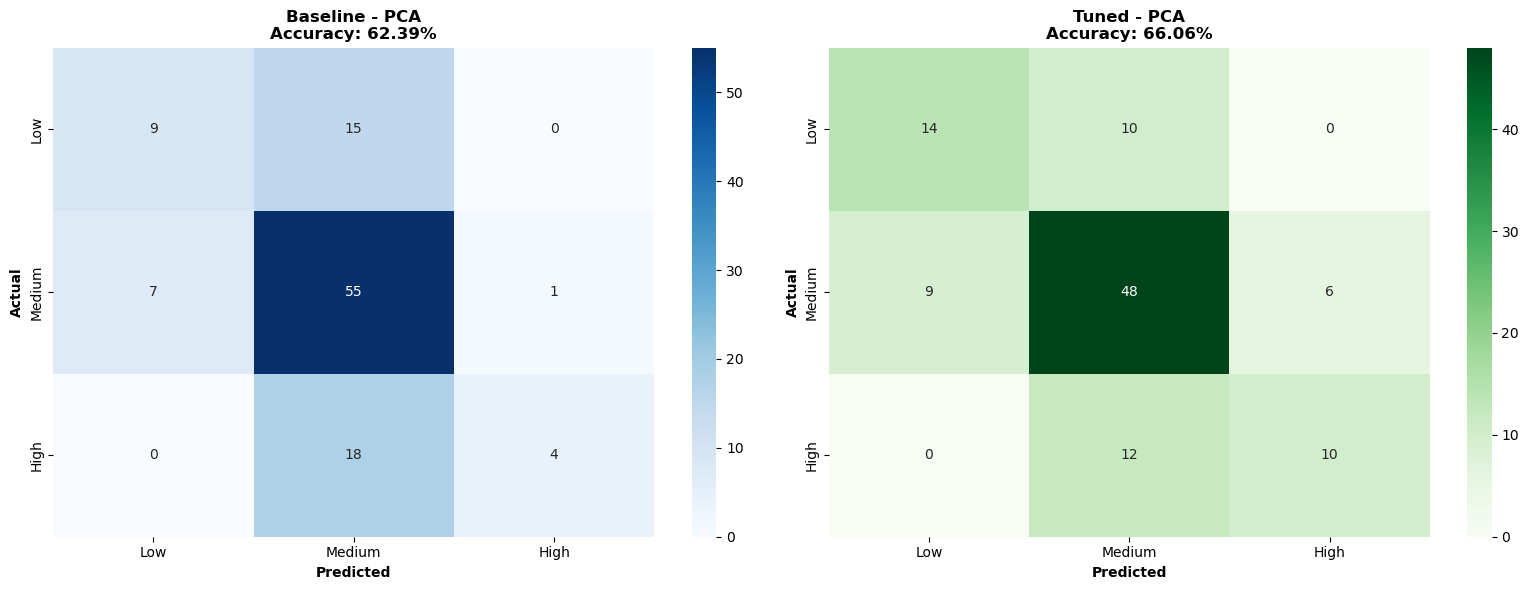


📊 CLASSIFICATION REPORT (Tuned Model - PCA)
              precision    recall  f1-score   support

         Low       0.61      0.58      0.60        24
      Medium       0.69      0.76      0.72        63
        High       0.62      0.45      0.53        22

    accuracy                           0.66       109
   macro avg       0.64      0.60      0.61       109
weighted avg       0.66      0.66      0.65       109



In [40]:
# Classification function
def classify_pKi(pKi_values):
    return np.array(['Low' if pKi < 6.0 else 'Medium' if pKi < 8.0 else 'High' for pKi in pKi_values])

# Convert to categories
y_test_cat = classify_pKi(y_test)
y_test_pred_baseline_cat = classify_pKi(y_test_pred)
y_test_pred_tuned_cat = classify_pKi(y_test_pred_tuned)

# Confusion matrices
cm_baseline = confusion_matrix(y_test_cat, y_test_pred_baseline_cat, labels=['Low', 'Medium', 'High'])
cm_tuned = confusion_matrix(y_test_cat, y_test_pred_tuned_cat, labels=['Low', 'Medium', 'High'])

# Side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
axes[0].set_title(f'Baseline - PCA\nAccuracy: {np.trace(cm_baseline)/cm_baseline.sum()*100:.2f}%', fontweight='bold')
axes[0].set_xlabel('Predicted', fontweight='bold')
axes[0].set_ylabel('Actual', fontweight='bold')

sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
tuned_acc = np.trace(cm_tuned)/cm_tuned.sum()*100
axes[1].set_title(f'Tuned - PCA\nAccuracy: {tuned_acc:.2f}%', fontweight='bold')
axes[1].set_xlabel('Predicted', fontweight='bold')
axes[1].set_ylabel('Actual', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("📊 CLASSIFICATION REPORT (Tuned Model - PCA)")
print("="*60)
print(classification_report(y_test_cat, y_test_pred_tuned_cat, labels=['Low', 'Medium', 'High']))
print("="*60)


## 📊 Step 8: Final Summary


In [41]:
print("="*80)
print("🎯 FINAL SUMMARY - XGBOOST REGRESSION (WITH PCA)")
print("="*80)
print(f"\n📊 Dataset:")
print(f"   Total compounds: {len(df_pca)}")
print(f"   Training: {len(X_train)} (80%), Test: {len(X_test)} (20%)")
print(f"   PCA components: {n_components} (95% variance, pre-computed)")
print(f"   Source: saved_models/processed_DAT_pca_features.csv")

print(f"\n🏆 Best Model Performance (Test Set):")
print(f"   R² Score: {test_r2_tuned:.4f}")
print(f"   RMSE: {test_rmse_tuned:.4f}")
print(f"   MAE: {test_mae_tuned:.4f}")
print(f"   Classification Accuracy: {tuned_acc:.2f}%")

print(f"\n💡 Key Insights:")
print(f"   • PCA reduced dimensionality from 17 to {n_components} features (done in dataanalyse.ipynb)")
print(f"   • XGBoost with PCA provides {'improved' if test_r2_tuned > 0.5 else 'reasonable'} generalization")
print(f"   • 80/20 split allows fair comparison with non-PCA XGBoost model")

print("\n" + "="*80)
print("✅ XGBoost with PCA Analysis Complete!")
print("="*80)


🎯 FINAL SUMMARY - XGBOOST REGRESSION (WITH PCA)

📊 Dataset:
   Total compounds: 541
   Training: 432 (80%), Test: 109 (20%)
   PCA components: 8 (95% variance, pre-computed)
   Source: saved_models/processed_DAT_pca_features.csv

🏆 Best Model Performance (Test Set):
   R² Score: 0.4769
   RMSE: 0.8234
   MAE: 0.6358
   Classification Accuracy: 66.06%

💡 Key Insights:
   • PCA reduced dimensionality from 17 to 8 features (done in dataanalyse.ipynb)
   • XGBoost with PCA provides reasonable generalization
   • 80/20 split allows fair comparison with non-PCA XGBoost model

✅ XGBoost with PCA Analysis Complete!


In [42]:
# Save XGBoost + PCA model and scaler
# Note: PCA transformer is saved in dataanalyse.ipynb
import os, joblib
os.makedirs('saved_models', exist_ok=True)

joblib.dump(best_xgb_model, 'saved_models/xgb_pca_model.pkl')
joblib.dump(scaler, 'saved_models/xgb_pca_scaler.pkl')
print("✅ Saved XGB+PCA model and scaler to saved_models/")
print("   (PCA transformer saved in dataanalyse.ipynb)")

✅ Saved XGB+PCA model and scaler to saved_models/
   (PCA transformer saved in dataanalyse.ipynb)
